In [1]:
from data_utils import extract_rectangles_from_xml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

In [2]:
annotation = extract_rectangles_from_xml('data/ai_challenge_s03_c010-full_annotation.xml')
parked_cars = annotation[0]

In [3]:
cap = cv2.VideoCapture('data/S03/c010/vdo.avi')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('Frame count:', frame_count, 'FPS:', fps)

split_frame = frame_count // 4

# Initialize cumulative sum and sum of squares
cum_sum = np.zeros((height, width), dtype=np.float64)
cum_sum_sq = np.zeros((height, width), dtype=np.float64)

for i in tqdm.tqdm(range(split_frame)):  # Process 25% of the frames
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float64)
    cum_sum += gray_frame
    cum_sum_sq += gray_frame ** 2

cap.release()

# Calculate mean and variance
mean = cum_sum / split_frame
variance = (cum_sum_sq / split_frame) - (mean ** 2)

Frame count: 2141 FPS: 10


  0%|          | 0/535 [00:00<?, ?it/s]

100%|██████████| 535/535 [00:43<00:00, 12.35it/s]


In [4]:
def remove_shadow_gabor(image):
    # Gabor filter parameters
    num = 8  # Number of different orientations
    vects = 8  # Number of different wavelengths (vector sizes)

    gabor_features = np.zeros((image.shape[0], image.shape[1], num * vects), dtype=np.double)

    for i in range(num):
        theta = i / num * np.pi
        for j in range(vects):
            lamda = int(image.shape[0] / (2 ** j))
            g_kernel = cv2.getGaborKernel((lamda, lamda), sigma=4.0, theta=theta, lambd=lamda, gamma=0.5)
            filtered_img = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
            gabor_features[:, :, i * vects + j] = filtered_img

    gabor_features_binary = (gabor_features.mean(axis=2) > 2.5*gabor_features.mean(axis=2).mean()).astype(np.uint8)

    
    # Find the columns that have non-zero values
    non_zero_columns = np.where(gabor_features_binary.sum(axis=0) > 0)[0]

    if len(non_zero_columns) == 0:
        return 0, image.shape[1]
    # The minimum and maximum x values with non-zero values (bbox horizontal)
    min_x = non_zero_columns.min()
    max_x = non_zero_columns.max()

    return min_x, max_x

# Function to calculate if rectangles a and b are close
def are_close(a, b, proximity_threshold):
    left_a, top_a, right_a, bottom_a = a
    left_b, top_b, right_b, bottom_b = b

    # Check if rectangles are close based on the threshold
    horizontal_close = (left_b <= right_a + proximity_threshold and right_b >= left_a - proximity_threshold)
    vertical_close = (top_b <= bottom_a + proximity_threshold and bottom_b >= top_a - proximity_threshold)

    return horizontal_close and vertical_close

# Function to merge two rectangles
def merge_rects(a, b):
    left_a, top_a, right_a, bottom_a = a
    left_b, top_b, right_b, bottom_b = b
    return (min(left_a, left_b), min(top_a, top_b), max(right_a, right_b), max(bottom_a, bottom_b))

def merge_close_rectangles(rectangles, proximity_threshold):
    # Convert rectangles to a format that includes the bottom-right corner for easier comparison
    rects_with_br = [(x, y, x+w, y+h) for x, y, w, h in rectangles]

    merged = True
    while merged:
        merged = False
        new_rects = []
        while rects_with_br:
            current = rects_with_br.pop(0)
            for i, other in enumerate(rects_with_br):
                if are_close(current, other, proximity_threshold):
                    new_rect = merge_rects(current, other)
                    rects_with_br[i] = new_rect  # Replace the "other" rect with the merged one
                    current = new_rect  # Update current to be the merged rect
                    merged = True
                    break
            else:
                new_rects.append(current)  # Add current rect if it wasn't merged
        rects_with_br = new_rects  # Update list with merged rects

    # Convert back to original format
    merged_rectangles = [(left, top, right-left, bottom-top) for left, top, right, bottom in rects_with_br]
    return merged_rectangles

In [5]:
gt_bbox = [
    [list(np.array(r).astype(int)) for r in rect if r not in parked_cars]
    for rect in list(annotation.values())[split_frame:]
]

In [6]:
def process_frame(frame, mean, variance, alpha):
    """Process a single frame to extract foreground bounding boxes."""
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    abs_diff = np.abs(gray_frame - mean)
    foreground_mask = abs_diff >= alpha * (np.sqrt(variance) + 2)
    foreground = np.where(foreground_mask, gray_frame, 0)
    # plt.imshow(foreground, cmap='gray')
    # plt.show()
    _, foreground_binary = cv2.threshold(foreground, 30, 255, cv2.THRESH_BINARY)
    # plt.imshow(foreground_binary, cmap='gray')
    # plt.show()
    foreground_clean = cv2.morphologyEx(foreground_binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    foreground_clean = cv2.morphologyEx(foreground_clean, cv2.MORPH_OPEN, np.ones((7,7), np.uint8))
    # plt.imshow(foreground_clean, cmap='gray')
    # plt.show()

    contours, _ = cv2.findContours(foreground_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles_merged = merge_close_rectangles([cv2.boundingRect(contour) for contour in contours], 30)

    return [(x + remove_shadow_gabor(gray_frame[y:y+h, x:x+w])[0], y, x+w, y+h) 
            for x, y, w, h in rectangles_merged if w >= 50 and h >= 50], foreground_binary

def process_video(video_path, split_frame, frame_count, mean, variance, gt_bbox, alpha):
    """Process the video to overlay predicted and ground truth bounding boxes."""
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    for n in range(split_frame+1200, frame_count, 100):
        out = cv2.VideoWriter(f'media/output_{n-split_frame}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height))
        out2 = cv2.VideoWriter(f'media/output_{n-split_frame}_binary.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (frame_width, frame_height), isColor=False)
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        pred_bbox = []

        for j in tqdm.tqdm(range(n, min(n+100, frame_count))):
            ret, frame = cap.read()
            if not ret:
                break
            bbox, binary = process_frame(frame, mean, variance, alpha)
            pred_bbox.append(bbox)
            out2.write(binary)

        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        for i, _ in enumerate(tqdm.tqdm(pred_bbox, total=len(pred_bbox))):
            ret, frame = cap.read()
            if not ret:
                break

            for rect in pred_bbox[i]:
                cv2.rectangle(frame, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)
            # Assuming gt_bbox is defined elsewhere and accessible here
            for rect in gt_bbox[n + i - split_frame]:
                cv2.rectangle(frame, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)

            out.write(frame)
        
        out.release()
        out2.release()
        break
        
    cap.release()

process_video('data/S03/c010/vdo.avi', split_frame, frame_count, mean, variance, gt_bbox, 10)

100%|██████████| 100/100 [00:03<00:00, 26.01it/s]


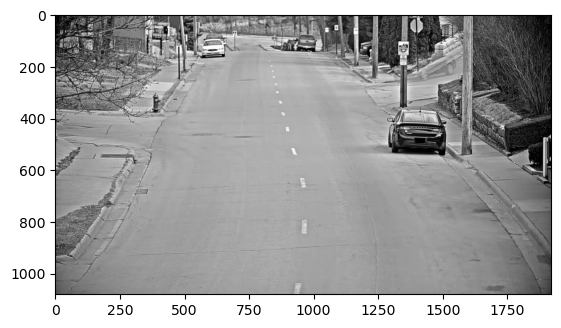

In [10]:
plt.imshow(mean, cmap='gray')